In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd053dcbd0>,
      dtype=object)

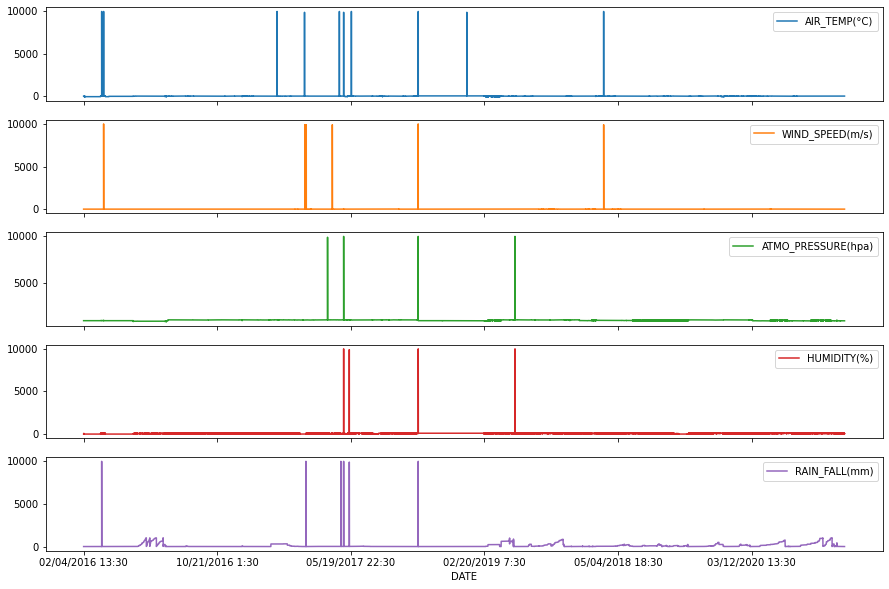

In [ ]:
df = pd.read_csv(root+'west_bengal_isro.csv')
df['DATE'] = df['DATE(IST)'] + " " + df['TIME(IST)']
df.drop(columns=['@STATION_ID', 'ALTITUDE(m)', 'WIND_DIRECTION(deg)', 'SUN_SHINE(hh:mm)','BATTERY_VOLTAGE(V)','TIME(GMT)', 'DATE(GMT)', 'TIME(IST)', 'DATE(IST)', 'LATITUDE', 'LONGITUDE'])
df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd05eaaf10>,
      dtype=object)

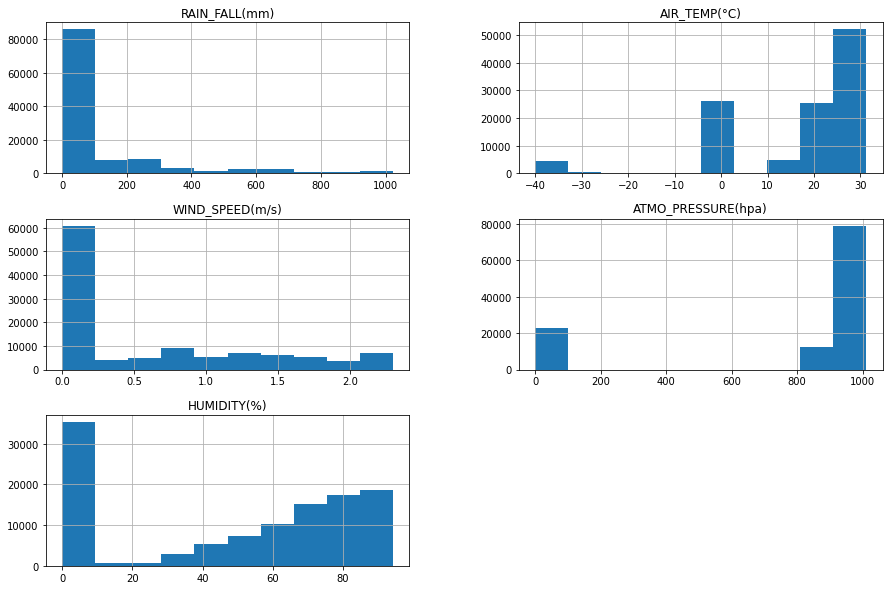

In [ ]:
df_input=df[['RAIN_FALL(mm)','AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)']]
for i in df_input.columns:
  if(i == 'RAIN_FALL(mm)'):
    a = df_input[i] > 2000
    df_input[i][a] = 0
  elif (i == 'DATE'):
    continue
  else:
    a = df_input[i].quantile(0.80)
    b = df_input[i] > a
    df_input[i][b] = 0
df_input.hist(figsize = (15, 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd1a625110>,
      dtype=object)

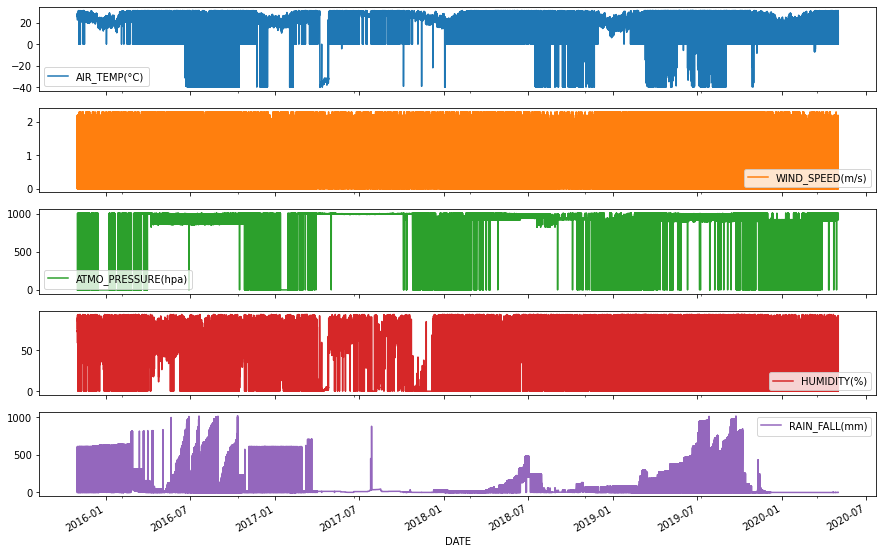

In [ ]:
df_input['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y %H:%M")
df_input.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True, figsize=(15, 10))

In [ ]:
df_input.to_csv(root+'corrected/west_bengal.csv', header=True, index=False)
df_input.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,113899.000000,113899.000000,113899.000000,113899.000000,113899.000000
mean,98.056954,16.454524,0.592694,766.725103,48.380487
std,190.582156,16.060579,0.747329,384.444150,35.407244
min,0.000000,-40.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,900.800000,0.100000
50%,8.000000,23.000000,0.000000,925.000000,61.000000
75%,97.000000,27.900000,1.200000,999.800000,79.700000
max,1023.000000,31.200000,2.300000,1010.400000,94.200000


## Data split
Split the data into training and test set 

In [ ]:
datelist = df_input['DATE']
print(datelist)
df_input = df_input.drop('DATE', 1)
training_set = df_input

0        2016-02-04 13:30:00
1        2016-02-04 14:30:00
2        2016-02-04 15:30:00
3        2016-02-04 16:30:00
4        2016-02-04 17:30:00
                 ...        
113894   2020-04-25 12:30:00
113895   2020-04-26 08:30:00
113896   2020-04-26 09:30:00
113897   2020-04-26 12:30:00
113898   2020-04-27 11:30:00
Name: DATE, Length: 113899, dtype: datetime64[ns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []

n_future = 1   
n_past = 60     

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0:df.shape[1] - 1])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (113839, 60, 5).
y_train shape == (113839, 1, 5).


In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_input.shape[1])))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=5, activation='linear'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,), loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath= root+'all_predictions_rain_wb_week5_lstm_isro.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=12, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=126)

Epoch 1/12
723/723 [==============================] - ETA: 0s - loss: 0.9867
Epoch 1: val_loss improved from inf to 1.08568, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_rain_wb_week5_lstm_isro.h5
723/723 [==============================] - 27s 32ms/step - loss: 0.9867 - val_loss: 1.0857 - lr: 0.0010
Epoch 2/12
723/723 [==============================] - ETA: 0s - loss: 0.9861
Epoch 2: val_loss improved from 1.08568 to 1.07940, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_rain_wb_week5_lstm_isro.h5
723/723 [==============================] - 23s 32ms/step - loss: 0.9861 - val_loss: 1.0794 - lr: 0.0010
Epoch 3/12
723/723 [==============================] - ETA: 0s - loss: 0.9859
Epoch 3: val_loss did not improve from 1.07940
723/723 [==============================] - 22s 31ms/step - loss: 0.9859 - val_loss: 1.0821 - lr: 0.0010
Epoch 4/12
723/723 [====================

In [ ]:
datelist_future = pd.date_range(datelist.iloc[-1], periods=90, freq='1d').tolist()
predictions_future = model.predict(X_train[-90:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
y_pred_future = sc.inverse_transform(predictions_future)
y_pred_train = sc.inverse_transform(predictions_train)
df_input['DATE'] = datelist

In [ ]:
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['RAIN_FALL(mm)',	'AIR_TEMP(°C)',	'WIND_SPEED(m/s)',	'ATMO_PRESSURE(hpa)',	'HUMIDITY(%)']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

In [ ]:
PREDICTION_TRAIN

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
DATE,,,,,
2016-06-26 19:30:00,75.235321,15.306242,0.557357,759.737305,44.165752
2016-06-26 20:30:00,75.235985,15.306067,0.557360,759.735107,44.165760
2016-06-26 21:30:00,75.236557,15.305922,0.557361,759.733398,44.165768
2016-06-26 22:30:00,75.237053,15.305802,0.557362,759.732056,44.165779
2016-06-26 23:30:00,75.237495,15.305706,0.557363,759.730957,44.165794
...,...,...,...,...,...
2020-04-25 12:30:00,75.045975,15.669935,0.559635,759.729187,44.458748
2020-04-26 08:30:00,75.034485,15.692516,0.559088,759.813721,44.426022
2020-04-26 09:30:00,75.057785,15.702795,0.558421,759.846924,44.425732


In [ ]:
PREDICTION_TRAIN.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,113779.000000,113779.000000,113779.000000,113779.000000,113779.000000
mean,75.824898,15.614709,0.559279,758.915710,44.369041
std,1.353575,0.091192,0.002017,2.292122,0.267352
min,74.428581,15.251889,0.554326,753.312439,43.770374
25%,74.972084,15.563656,0.557364,759.182831,44.165863
50%,75.258827,15.639150,0.559324,759.894836,44.463131
75%,75.878738,15.684664,0.560792,760.547974,44.584204
max,81.868828,15.753469,0.565879,762.690918,44.906796


In [ ]:
df_input.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,113899.000000,113899.000000,113899.000000,113899.000000,113899.000000
mean,98.056954,16.454524,0.592694,766.725103,48.380487
std,190.582156,16.060579,0.747329,384.444150,35.407244
min,0.000000,-40.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,900.800000,0.100000
50%,8.000000,23.000000,0.000000,925.000000,61.000000
75%,97.000000,27.900000,1.200000,999.800000,79.700000
max,1023.000000,31.200000,2.300000,1010.400000,94.200000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd439e6fd0>,
      dtype=object)

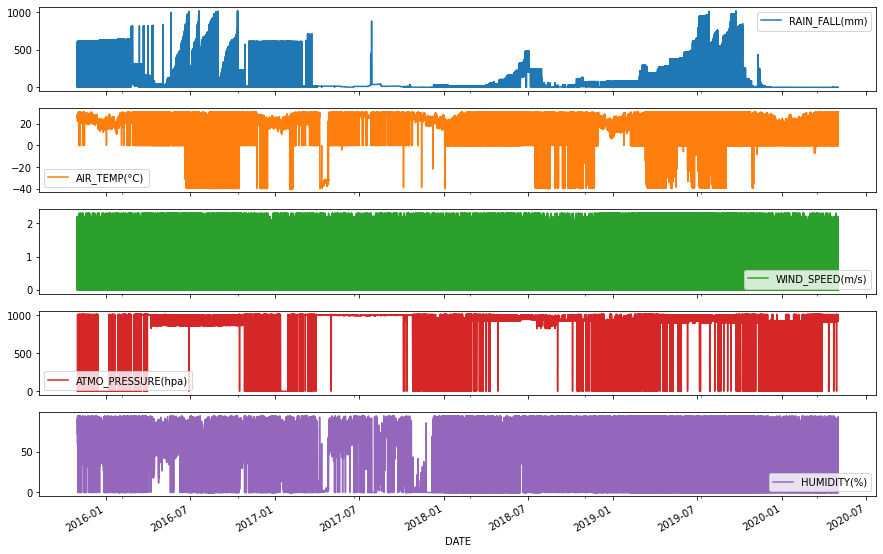

In [ ]:
df_input.set_index('DATE').plot(subplots=True, figsize=(15, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd439e63d0>,
      dtype=object)

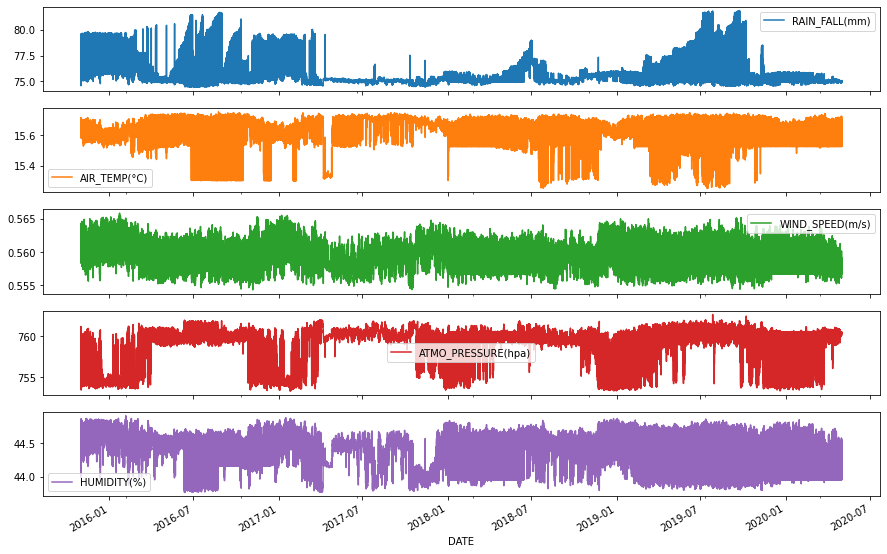

In [ ]:
PREDICTION_TRAIN.plot(subplots=True, figsize=(15, 10))

(113779,)
(113779,)


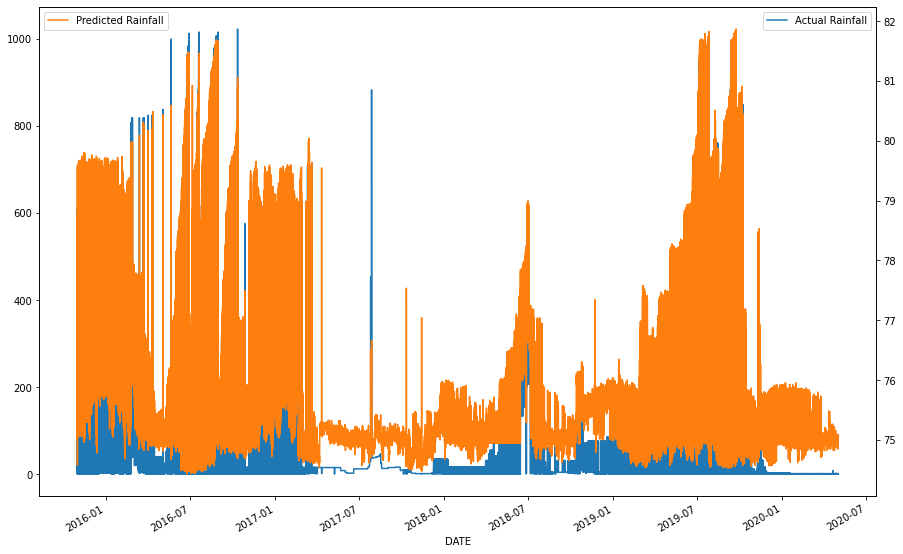

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
print(df_input['RAIN_FALL(mm)'][2 * n_past + n_future -1:].shape)
print(PREDICTION_TRAIN['RAIN_FALL(mm)'].shape)
df_input.set_index('DATE')['RAIN_FALL(mm)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Rainfall'])
PREDICTION_TRAIN['RAIN_FALL(mm)'].plot(secondary_y=True)
plt.legend(['Predicted Rainfall'],loc = 2)

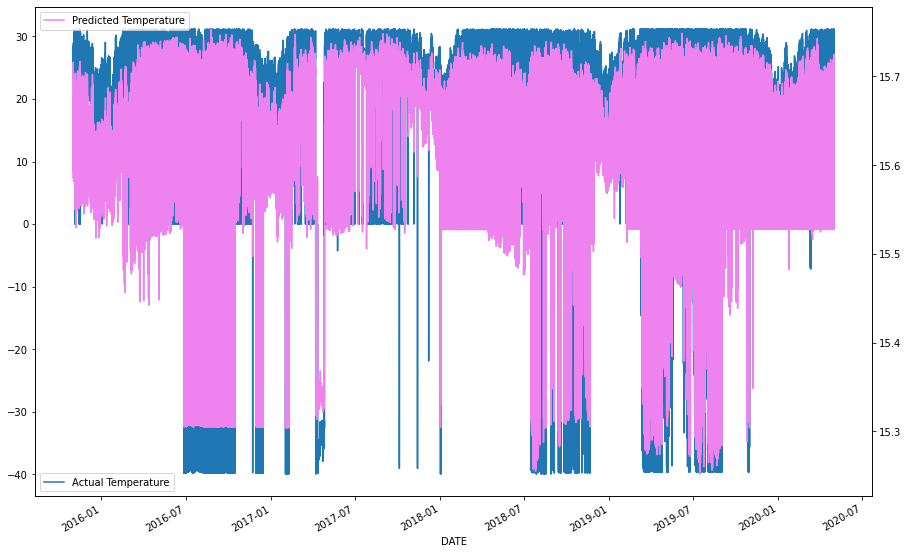

In [ ]:
df_input.set_index('DATE')['AIR_TEMP(°C)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Temperature'])
PREDICTION_TRAIN['AIR_TEMP(°C)'].plot(secondary_y=True, color='violet')
plt.legend(['Predicted Temperature'],loc = 2)

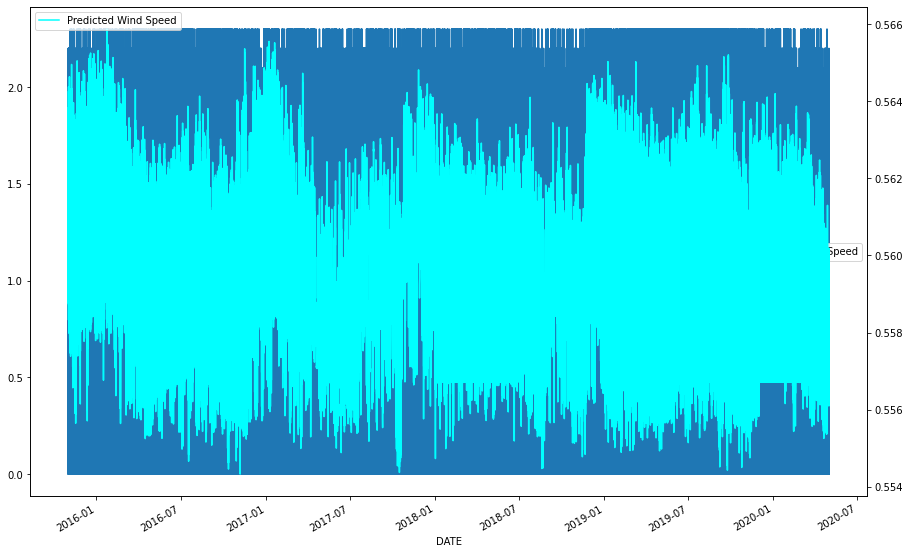

In [ ]:
df_input.set_index('DATE')['WIND_SPEED(m/s)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Wind Speed'])
PREDICTION_TRAIN['WIND_SPEED(m/s)'].plot(secondary_y=True, color='cyan')
plt.legend(['Predicted Wind Speed'],loc = 2)

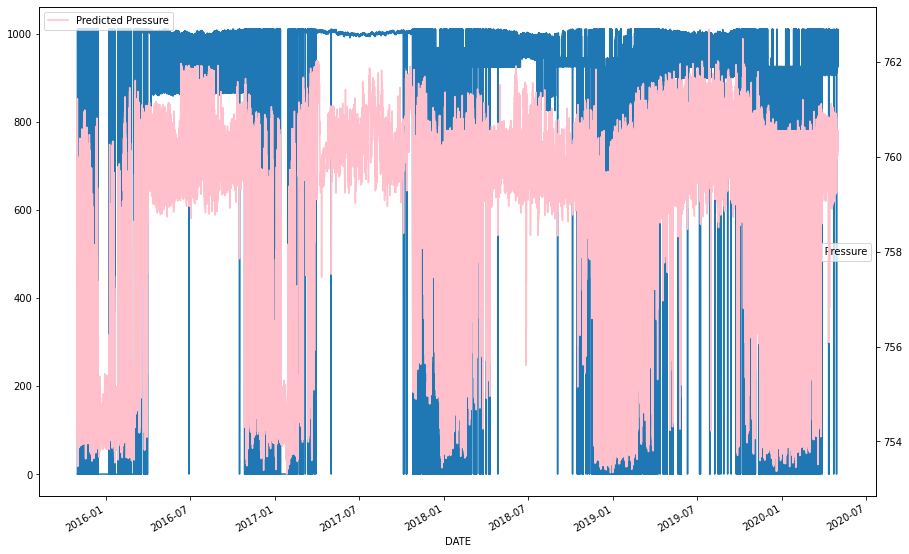

In [ ]:
df_input.set_index('DATE')['ATMO_PRESSURE(hpa)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Pressure'])
PREDICTION_TRAIN['ATMO_PRESSURE(hpa)'].plot(secondary_y=True, color='pink')
plt.legend(['Predicted Pressure'],loc = 2)

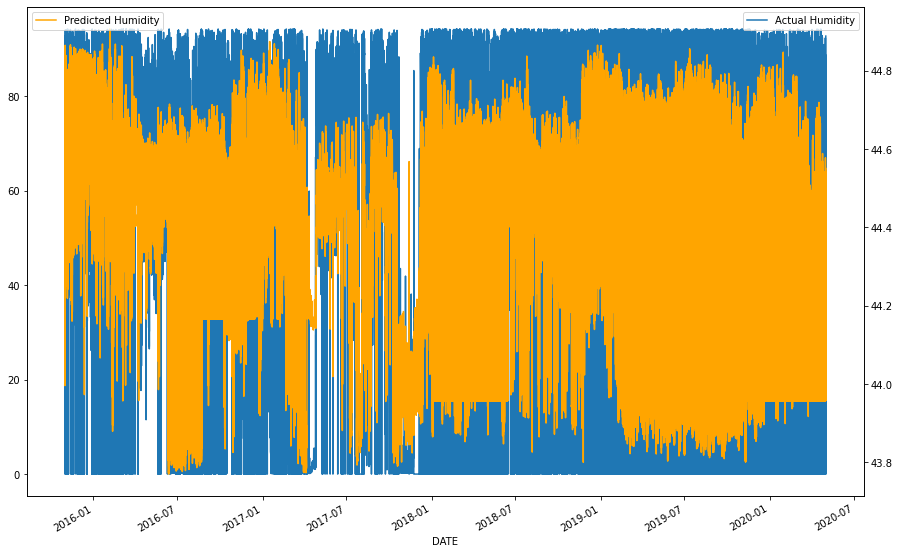

In [ ]:
df_input.set_index('DATE')['HUMIDITY(%)'][2 * n_past + n_future -1:].plot()
plt.legend(['Actual Humidity'])
PREDICTION_TRAIN['HUMIDITY(%)'].plot(secondary_y=True, color='orange')
plt.legend(['Predicted Humidity'],loc = 2)

In [ ]:
#HOW WE FILTERED THE ORIGINAL DATASET

# df = pd.read_csv(root+'himachal_pradesh_isro.csv')
# df['DATE'] = pd.to_datetime((df['DATE(IST)'] + " " + df['TIME(IST)']), format="%m/%d/%Y %H:%M")
# df = df.groupby('DATE').mean().reset_index()
# df.drop(columns=['ALTITUDE(m)', 'WIND_DIRECTION(deg)','BATTERY_VOLTAGE(V)','TIME(GMT)', 'LATITUDE', 'LONGITUDE'], inplace = True)
# df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))
# df.to_csv(root+'corrected/ORIG_CORRECTED_himachal_pradesh.csv', header=True, index=False)